# Tokenization Visualization

This interactive notebook demonstrates how text is split into tokens by different tokenization methods. Understanding tokenization is crucial because it's the first step in how language models process text.

## What is Tokenization?

Tokenization is the process of breaking text into smaller units called tokens. These tokens serve as the basic units that language models process. Different tokenization strategies lead to different ways of understanding and representing text.

## What You'll Learn

- How different tokenization methods work
- Visualizing token boundaries in text
- Comparing tokenization approaches
- How tokenization affects model understanding
- Token frequency analysis


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
import ipywidgets as widgets
from IPython.display import display, HTML, clear_output
import nltk
from nltk.tokenize import word_tokenize, wordpunct_tokenize, RegexpTokenizer
import random
from transformers import AutoTokenizer

# Download necessary NLTK data
nltk.download("punkt")

# Set styling
plt.style.use("ggplot")
sns.set_palette("viridis")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\super\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Types of Tokenization

Let's explore different tokenization strategies:

1. **Character-level**: Split text into individual characters
2. **Word-level**: Split text into words (with various rules for handling punctuation)
3. **Subword**: More advanced techniques that break words into meaningful subunits (like BPE, WordPiece, etc.)

We'll implement and visualize each of these approaches.


In [ ]:
def character_tokenize(text):
    """Split text into individual characters"""
    return list(text)


def simple_word_tokenize(text):
    """Simple space-based word tokenization"""
    return text.split()


def nltk_word_tokenize(text):
    """NLTK's word tokenizer"""
    return word_tokenize(text)


def wordpunct_tokenize_text(text):
    """NLTK's wordpunct tokenizer - separates punctuation"""
    return wordpunct_tokenize(text)


# Load pre-trained tokenizers for subword demonstration
bert_tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
gpt2_tokenizer = AutoTokenizer.from_pretrained("gpt2")
t5_tokenizer = AutoTokenizer.from_pretrained("t5-small")


def bert_subword_tokenize(text):
    """BERT tokenizer (WordPiece)"""
    tokens = bert_tokenizer.tokenize(text)
    return tokens


def gpt2_subword_tokenize(text):
    """GPT-2 tokenizer (BPE)"""
    tokens = gpt2_tokenizer.tokenize(text)
    return tokens


def t5_subword_tokenize(text):
    """T5 tokenizer (SentencePiece)"""
    tokens = t5_tokenizer.tokenize(text)
    return tokens

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

## Sample Texts

Let's define some sample texts to use for our tokenization demonstrations.


In [ ]:
sample_texts = {
    "Simple sentence": "The quick brown fox jumps over the lazy dog.",
    "Technical text": "Python 3.9 was released on October 5th, 2020 with new features like dictionary union operators.",
    "Punctuation example": "Hello, world! How's it going? This is a test...",
    "Numbers and symbols": "Price: $19.99 (25% off) - Call +1-555-123-4567 for details!",
    "Scientific jargon": "The mitochondria is the powerhouse of the cell, performing ATP synthesis via oxidative phosphorylation.",
    "Multi-language": "Buenos días! Comment ça va? Ich bin ein programmer and I ❤️ coding.",
    "OOV words": "Supercalifragilisticexpialidocious is an antidisestablishmentarianism word with pneumonoultramicroscopicsilicovolcanoconiosis tendencies.",
}

# Display sample texts in a nice table
pd.DataFrame(list(sample_texts.items()), columns=["Description", "Text"]).style.set_properties(
    **{"text-align": "left", "white-space": "pre-wrap"}
)

,Description,Text
0,Simple sentence,The quick brown fox jumps over the lazy dog.
1,Technical text,"Python 3.9 was released on October 5th, 2020 with new features like dictionary union operators."
2,Punctuation example,"Hello, world! How's it going? This is a test..."
3,Numbers and symbols,Price: $19.99 (25% off) - Call +1-555-123-4567 for details!
4,Scientific jargon,"The mitochondria is the powerhouse of the cell, performing ATP synthesis via oxidative phosphorylation."
5,Multi-language,Buenos días! Comment ça va? Ich bin ein programmer and I ❤️ coding.
6,OOV words,Supercalifragilisticexpialidocious is an antidisestablishmentarianism word with pneumonoultramicroscopicsilicovolcanoconiosis tendencies.


## Visualization Functions

Now let's create functions to visualize the tokenization results in different ways.


In [ ]:
def visualize_tokens_table(text, tokenizer_function, tokenizer_name):
    """Display tokens in a table format with indices"""
    tokens = tokenizer_function(text)

    df = pd.DataFrame(
        {"Token": tokens, "Index": range(len(tokens)), "Length": [len(token) for token in tokens]}
    )

    display(HTML(f"<h3>Tokenization using {tokenizer_name}:</h3>"))
    display(HTML(f"<p>Total tokens: {len(tokens)}</p>"))
    return df


def highlight_tokens_in_text(text, tokenizer_function, tokenizer_name):
    """Highlight token boundaries in the original text"""
    tokens = tokenizer_function(text)

    # For character-level tokenization, just return the tokens
    if tokenizer_function == character_tokenize:
        highlighted_text = " ".join(tokens)
        display(HTML(f"<h3>Character tokenization visualization:</h3>"))
        display(
            HTML(
                f"<p style='font-family:monospace; font-size:16px; line-height:2.5'>{highlighted_text}</p>"
            )
        )
        return

    # For word or subword tokenization
    highlighted_text = ""

    # Handle different tokenizers
    if tokenizer_function in [bert_subword_tokenize, gpt2_subword_tokenize, t5_subword_tokenize]:
        # For subword tokenizers, use their internal functions to get offsets
        if tokenizer_function == bert_subword_tokenize:
            encoding = bert_tokenizer(text, return_offsets_mapping=True)
        elif tokenizer_function == gpt2_subword_tokenize:
            encoding = gpt2_tokenizer(text, return_offsets_mapping=True)
        else:  # t5
            encoding = t5_tokenizer(text, return_offsets_mapping=True)

        # Get the offsets
        offsets = encoding.offset_mapping

        # Create HTML with highlighting
        html_parts = []
        last_end = 0
        colors = generate_distinct_colors(len(offsets))

        for i, (start, end) in enumerate(offsets):
            if start == end:  # Special tokens have (0,0) offsets
                continue

            # Add any text between the last token and this one
            if start > last_end:
                html_parts.append(text[last_end:start])

            # Add the highlighted token
            token_text = text[start:end]
            html_parts.append(f"<span style='background-color:{colors[i]}'>{token_text}</span>")
            last_end = end

        # Add any remaining text
        if last_end < len(text):
            html_parts.append(text[last_end:])

        highlighted_text = "".join(html_parts)
    else:
        # For word tokenizers, we'll use a simpler approach
        # This is an approximation and might not work perfectly for all tokenizers
        current_pos = 0
        colors = generate_distinct_colors(len(tokens))

        for i, token in enumerate(tokens):
            # Find the token in the original text
            # This is a simplification and might not work for all cases
            token_stripped = token.strip()
            pos = text.find(token_stripped, current_pos)

            if pos == -1:  # Token not found, try with original token
                pos = text.find(token, current_pos)
                if pos == -1:  # Still not found
                    continue
                token_stripped = token

            # Add text before token
            highlighted_text += text[current_pos:pos]

            # Add highlighted token
            highlighted_text += f"<span style='background-color:{colors[i]}'>{text[pos:pos+len(token_stripped)]}</span>"

            # Update position
            current_pos = pos + len(token_stripped)

        # Add any remaining text
        highlighted_text += text[current_pos:]

    display(HTML(f"<h3>{tokenizer_name} visualization:</h3>"))
    display(
        HTML(
            f"<p style='font-family:monospace; font-size:16px; line-height:2.5'>{highlighted_text}</p>"
        )
    )


def generate_distinct_colors(n):
    """Generate n visually distinct colors"""
    hsv_colors = [
        (i / n, 0.5 + random.uniform(-0.2, 0.2), 0.9 + random.uniform(-0.1, 0.1)) for i in range(n)
    ]

    # Convert HSV to RGB and then to hex
    import colorsys

    rgb_colors = [colorsys.hsv_to_rgb(*hsv) for hsv in hsv_colors]
    hex_colors = [
        "#%02x%02x%02x" % (int(r * 255), int(g * 255), int(b * 255)) for r, g, b in rgb_colors
    ]

    return hex_colors


def token_frequency_analysis(text, tokenizer_function, tokenizer_name):
    """Analyze token frequencies"""
    tokens = tokenizer_function(text)
    token_counts = Counter(tokens)

    # Create DataFrame
    df = pd.DataFrame(token_counts.items(), columns=["Token", "Frequency"])
    df = df.sort_values("Frequency", ascending=False).reset_index(drop=True)

    # Limit to top 20 tokens for visualization
    df_plot = df.head(20)

    # Plot
    plt.figure(figsize=(12, 6))
    sns.barplot(x="Frequency", y="Token", data=df_plot)
    plt.title(f"Top Token Frequencies using {tokenizer_name}")
    plt.xlabel("Frequency")
    plt.ylabel("Token")
    plt.tight_layout()
    plt.show()

    return df

## Comparison of Different Tokenization Methods

Let's compare how different tokenizers process the same text.


In [ ]:
def compare_tokenizers(text):
    tokenizers = [
        (character_tokenize, "Character-level"),
        (simple_word_tokenize, "Simple word (space-based)"),
        (nltk_word_tokenize, "NLTK word"),
        (wordpunct_tokenize_text, "NLTK wordpunct"),
        (bert_subword_tokenize, "BERT (WordPiece)"),
        (gpt2_subword_tokenize, "GPT-2 (BPE)"),
        (t5_subword_tokenize, "T5 (SentencePiece)"),
    ]

    display(HTML(f"<h2>Text: {text}</h2>"))

    # Get token counts for each tokenizer
    token_counts = {}
    for tokenizer_func, tokenizer_name in tokenizers:
        tokens = tokenizer_func(text)
        token_counts[tokenizer_name] = len(tokens)

    # Create comparison table
    comparison_df = pd.DataFrame(list(token_counts.items()), columns=["Tokenizer", "Token Count"])
    display(comparison_df)

    # Plot comparison
    plt.figure(figsize=(12, 6))
    sns.barplot(x="Token Count", y="Tokenizer", data=comparison_df)
    plt.title("Comparison of Token Counts Across Tokenizers")
    plt.xlabel("Number of Tokens")
    plt.tight_layout()
    plt.show()

    # Show detailed tokenization for each method
    for tokenizer_func, tokenizer_name in tokenizers:
        tokens = tokenizer_func(text)
        display(HTML(f"<h3>{tokenizer_name} tokens:</h3>"))
        display(HTML(f"<p>{tokens}</p>"))

## Interactive Tokenization Demo

Try different text inputs and tokenization methods interactively!


In [ ]:
tokenizer_options = [
    ("Character-level", character_tokenize),
    ("Simple word (space-based)", simple_word_tokenize),
    ("NLTK word", nltk_word_tokenize),
    ("NLTK wordpunct", wordpunct_tokenize_text),
    ("BERT (WordPiece)", bert_subword_tokenize),
    ("GPT-2 (BPE)", gpt2_subword_tokenize),
    ("T5 (SentencePiece)", t5_subword_tokenize),
]

# Create dropdown for sample texts
sample_dropdown = widgets.Dropdown(
    options=list(sample_texts.keys()),
    value=list(sample_texts.keys())[0],
    description="Sample Text:",
    style={"description_width": "initial"},
    layout=widgets.Layout(width="50%"),
)

# Create text area for custom input
text_input = widgets.Textarea(
    value=sample_texts[list(sample_texts.keys())[0]],
    placeholder="Enter your text here",
    description="Or enter custom text:",
    style={"description_width": "initial"},
    layout=widgets.Layout(width="90%", height="100px"),
)

# Create dropdown for tokenizer selection
tokenizer_dropdown = widgets.Dropdown(
    options=[name for name, _ in tokenizer_options],
    value=tokenizer_options[0][0],
    description="Tokenizer:",
    style={"description_width": "initial"},
    layout=widgets.Layout(width="50%"),
)

# Create visualization options
viz_options = widgets.Dropdown(
    options=["Text highlighting", "Token table", "Token frequencies", "All visualizations"],
    value="All visualizations",
    description="Visualization:",
    style={"description_width": "initial"},
    layout=widgets.Layout(width="50%"),
)

# Create button to run tokenization
button = widgets.Button(
    description="Tokenize Text",
    button_style="primary",
    tooltip="Click to tokenize the text",
    icon="play",
)

# Create compare button
compare_button = widgets.Button(
    description="Compare All Tokenizers",
    button_style="info",
    tooltip="Click to compare all tokenizers",
    icon="random",
)

# Output area
output = widgets.Output()


# Update text input when sample is selected
def update_text(change):
    text_input.value = sample_texts[change["new"]]


sample_dropdown.observe(update_text, names="value")


# Define button click handler
def on_button_clicked(b):
    with output:
        clear_output()
        text = text_input.value
        tokenizer_name = tokenizer_dropdown.value
        tokenizer_func = next(func for name, func in tokenizer_options if name == tokenizer_name)

        # Determine which visualizations to show
        viz_type = viz_options.value
        if viz_type in ["Text highlighting", "All visualizations"]:
            highlight_tokens_in_text(text, tokenizer_func, tokenizer_name)

        if viz_type in ["Token table", "All visualizations"]:
            df = visualize_tokens_table(text, tokenizer_func, tokenizer_name)
            display(df)

        if viz_type in ["Token frequencies", "All visualizations"]:
            token_frequency_analysis(text, tokenizer_func, tokenizer_name)


# Define compare button handler
def on_compare_clicked(b):
    with output:
        clear_output()
        compare_tokenizers(text_input.value)


# Register handlers
button.on_click(on_button_clicked)
compare_button.on_click(on_compare_clicked)

# Layout the widgets
display(
    widgets.VBox(
        [
            widgets.HBox([sample_dropdown]),
            text_input,
            widgets.HBox([tokenizer_dropdown, viz_options]),
            widgets.HBox([button, compare_button]),
            output,
        ]
    )
)

## Special Cases and Challenges in Tokenization

Let's explore some challenging cases for tokenization:

1. Languages without clear word boundaries (e.g., Chinese, Japanese)
2. Compounds words and hyphenation
3. Ambiguous cases
4. Out-of-vocabulary (OOV) words
5. Emojis and special characters


In [ ]:
special_cases = {
    "Chinese text": "我喜欢学习自然语言处理。",  # "I like learning natural language processing."
    "Japanese text": "私は東京に住んでいます。",  # "I live in Tokyo."
    "Compound words": "Checkout the check-out time at the checkout counter before check out.",
    "Contractions": "Don't won't can't shouldn't wouldn't isn't aren't I'll they'll we'll",
    "Emojis & symbols": "I ❤️ NLP! It's 🔥. The cost is $100 @ the store. #awesome 😊👍",
    "URLs & emails": "Visit https://www.example.com or email user@example.com for info.",
    "Hashtags & mentions": "#MachineLearning is trending. Follow @NLPResearcher for updates!",
}

# Create dropdown for special cases
special_dropdown = widgets.Dropdown(
    options=list(special_cases.keys()),
    value=list(special_cases.keys())[0],
    description="Special Case:",
    style={"description_width": "initial"},
    layout=widgets.Layout(width="50%"),
)

# Create text area for displaying the case
special_text = widgets.Textarea(
    value=special_cases[list(special_cases.keys())[0]],
    placeholder="Special case text",
    disabled=False,
    layout=widgets.Layout(width="90%", height="80px"),
)

# Create button to analyze special case
special_button = widgets.Button(
    description="Analyze Special Case",
    button_style="warning",
    tooltip="Compare tokenizers on this special case",
    icon="exclamation-triangle",
)

# Output area for special cases
special_output = widgets.Output()


# Update text when special case is selected
def update_special_text(change):
    special_text.value = special_cases[change["new"]]


special_dropdown.observe(update_special_text, names="value")


# Define button click handler for special cases
def on_special_button_clicked(b):
    with special_output:
        clear_output()
        compare_tokenizers(special_text.value)


# Register handler
special_button.on_click(on_special_button_clicked)

# Layout the widgets
display(widgets.HTML("<h2>Special Cases in Tokenization</h2>"))
display(widgets.VBox([special_dropdown, special_text, special_button, special_output]))

HTML(value='<h2>Special Cases in Tokenization</h2>')

## Token Efficiency Analysis

Different tokenization methods can be more or less efficient for different languages and contexts. Let's analyze the efficiency of different tokenizers.


,Text,Tokenizer,Characters,Tokens,Chars/Token
0,Simple sentence,Character-level,44,44,1.000000
1,Simple sentence,Simple word (space-based),44,9,4.888889
2,Simple sentence,NLTK word,44,10,4.400000
3,Simple sentence,NLTK wordpunct,44,10,4.400000
4,Simple sentence,BERT (WordPiece),44,10,4.400000
...,...,...,...,...,...
93,Hashtags & mentions,NLTK word,64,11,5.818182
94,Hashtags & mentions,NLTK wordpunct,64,11,5.818182
95,Hashtags & mentions,BERT (WordPiece),64,18,3.555556
96,Hashtags & mentions,GPT-2 (BPE),64,15,4.266667


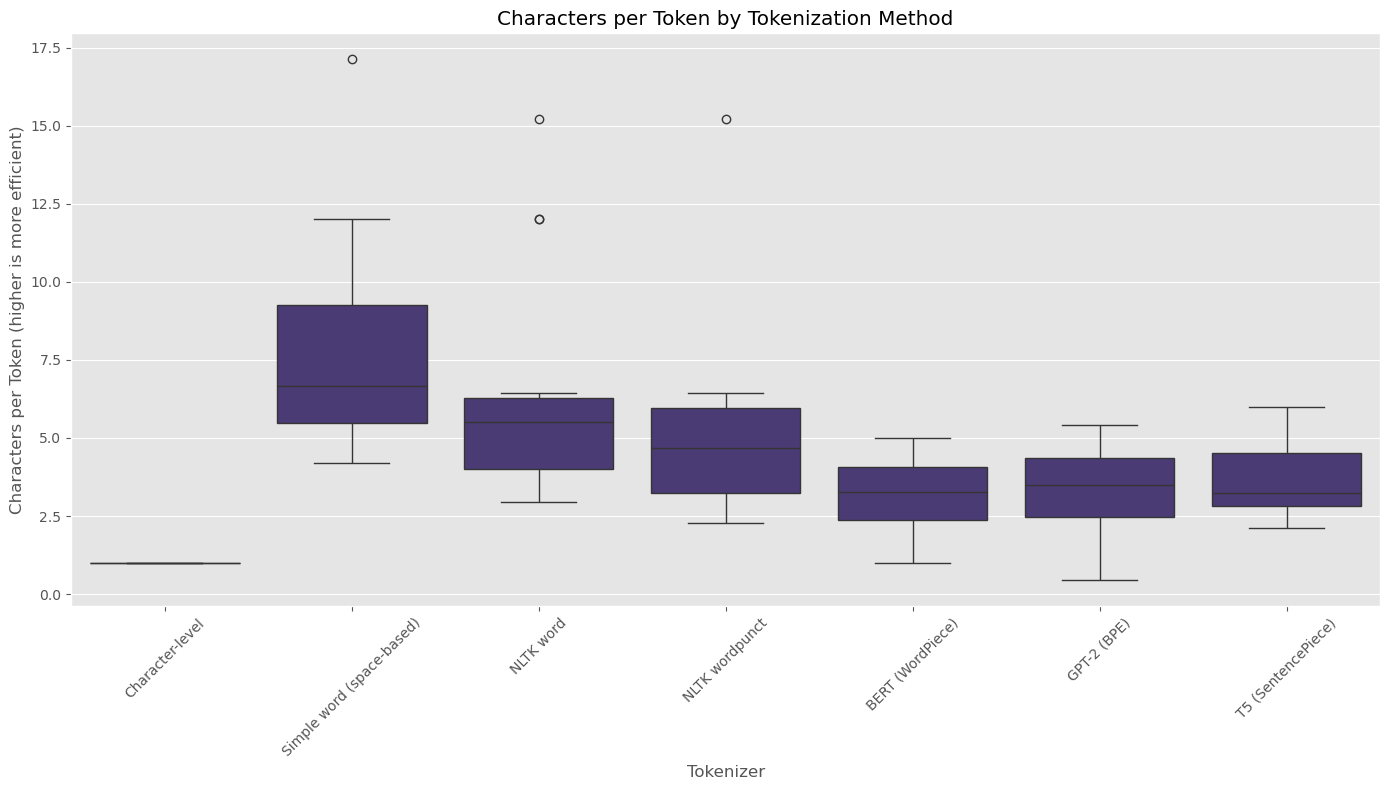

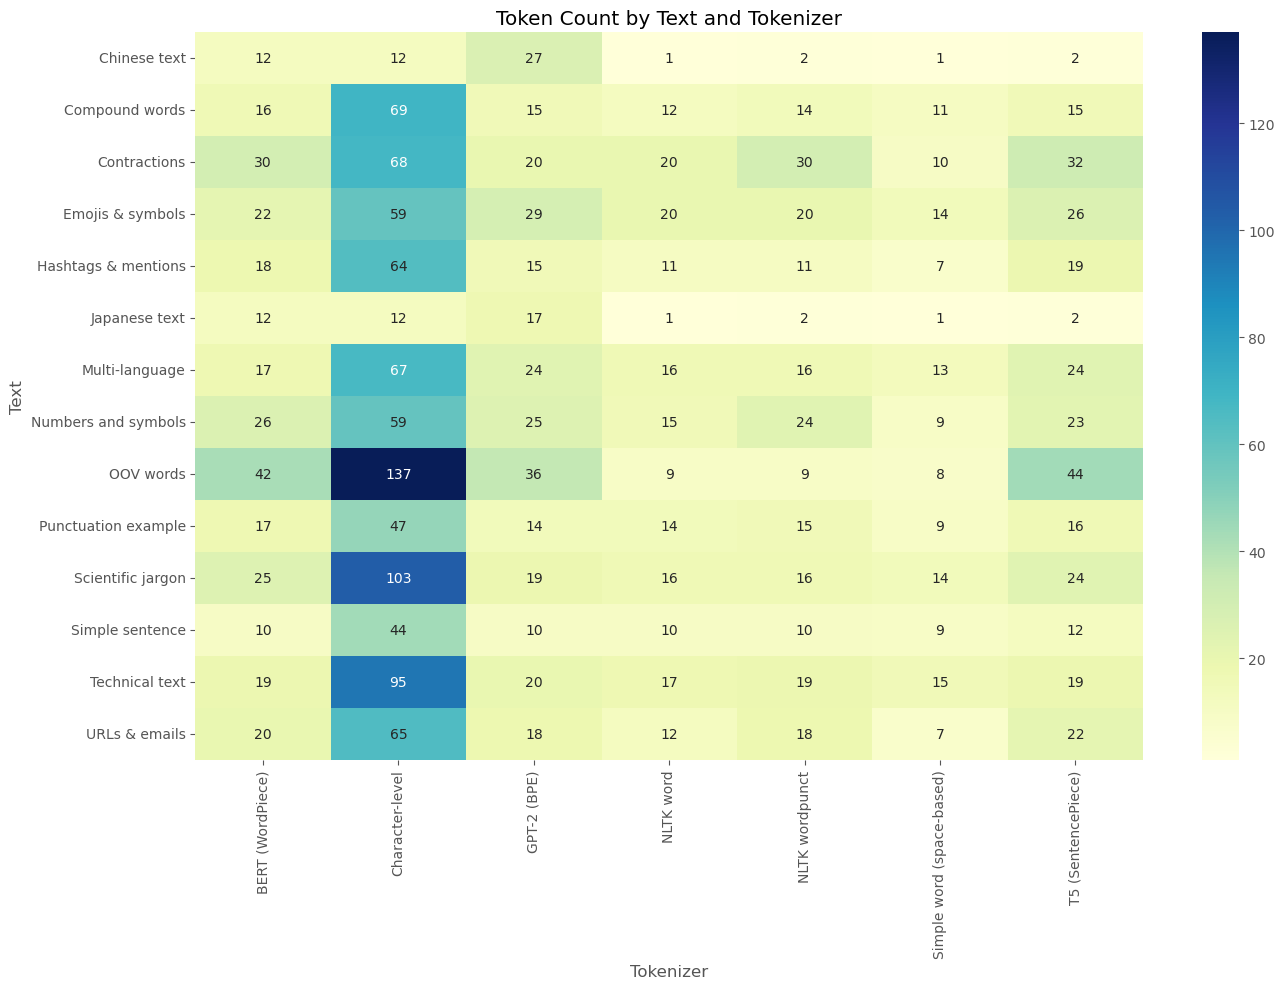

In [ ]:
def analyze_token_efficiency(texts, tokenizers):
    """Analyze the efficiency of different tokenizers across texts"""
    results = []

    for text_name, text in texts.items():
        for tokenizer_name, tokenizer_func in tokenizers:
            tokens = tokenizer_func(text)
            char_count = len(text)
            token_count = len(tokens)
            chars_per_token = char_count / token_count if token_count > 0 else 0

            results.append(
                {
                    "Text": text_name,
                    "Tokenizer": tokenizer_name,
                    "Characters": char_count,
                    "Tokens": token_count,
                    "Chars/Token": chars_per_token,
                }
            )

    return pd.DataFrame(results)


# Analyze all sample texts
efficiency_df = analyze_token_efficiency({**sample_texts, **special_cases}, tokenizer_options)

# Display results
display(HTML("<h2>Token Efficiency Analysis</h2>"))
display(efficiency_df)

# Visualize efficiency by tokenizer
plt.figure(figsize=(14, 8))
sns.boxplot(x="Tokenizer", y="Chars/Token", data=efficiency_df)
plt.title("Characters per Token by Tokenization Method")
plt.xticks(rotation=45)
plt.xlabel("Tokenizer")
plt.ylabel("Characters per Token (higher is more efficient)")
plt.tight_layout()
plt.show()

# Visualize token counts by text and tokenizer
plt.figure(figsize=(14, 10))
pivot_df = efficiency_df.pivot(index="Text", columns="Tokenizer", values="Tokens")
sns.heatmap(pivot_df, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Token Count by Text and Tokenizer")
plt.ylabel("Text")
plt.tight_layout()
plt.show()

## Practical Implications of Tokenization

Tokenization has significant practical implications for NLP tasks:

1. **Model Size**: The vocabulary size directly affects model size
2. **Training Efficiency**: Different tokenization strategies can make training more or less efficient
3. **Model Understanding**: How the model "sees" text affects its ability to understand meaning
4. **Token Limits**: Many LLMs have token limits (e.g., 2048, 4096 tokens), so efficient tokenization matters
5. **Multilingual Support**: Some tokenizers handle multiple languages better than others


## Token Limit Demonstration

Let's create a tool to visualize how much text fits within common token limits.


In [ ]:
# Text area for input
limit_text = widgets.Textarea(
    placeholder="Enter or paste a long document here to check token limits",
    layout=widgets.Layout(width="90%", height="200px"),
)

# Token limit selector
limit_dropdown = widgets.Dropdown(
    options=[
        ("512 tokens (BERT)", 512),
        ("1024 tokens", 1024),
        ("2048 tokens (GPT-2)", 2048),
        ("4096 tokens (GPT-3)", 4096),
        ("8192 tokens (GPT-4)", 8192),
        ("16384 tokens (Claude)", 16384),
    ],
    value=2048,
    description="Token Limit:",
    style={"description_width": "initial"},
)

# Tokenizer selector
limit_tokenizer = widgets.Dropdown(
    options=[
        name for name, _ in tokenizer_options if "Character" not in name
    ],  # Exclude character tokenizer
    value="GPT-2 (BPE)",  # Default to GPT-2 which is common
    description="Tokenizer:",
    style={"description_width": "initial"},
)

# Button to analyze
limit_button = widgets.Button(
    description="Analyze Token Usage",
    button_style="success",
    tooltip="Check how many tokens your text uses",
    icon="calculator",
)

# Output area
limit_output = widgets.Output()


# Handler for token limit check
def on_limit_button_clicked(b):
    with limit_output:
        clear_output()
        text = limit_text.value
        limit = limit_dropdown.value
        tokenizer_name = limit_tokenizer.value
        tokenizer_func = next(func for name, func in tokenizer_options if name == tokenizer_name)

        # Tokenize
        tokens = tokenizer_func(text)
        token_count = len(tokens)

        # Calculate statistics
        percentage = (token_count / limit) * 100
        within_limit = token_count <= limit

        # Display results
        display(HTML(f"<h3>Token Usage Analysis:</h3>"))
        display(HTML(f"<p>Text length: {len(text)} characters</p>"))
        display(HTML(f"<p>Token count: {token_count} tokens</p>"))
        display(HTML(f"<p>Token limit: {limit} tokens</p>"))
        display(HTML(f"<p>Usage: {percentage:.1f}% of limit</p>"))

        if within_limit:
            display(
                HTML(
                    f"<p style='color:green; font-weight:bold'>✓ Text is within the token limit</p>"
                )
            )
        else:
            display(
                HTML(
                    f"<p style='color:red; font-weight:bold'>✗ Text exceeds the token limit by {token_count - limit} tokens</p>"
                )
            )

        # Visualize
        plt.figure(figsize=(10, 2))
        plt.barh([0], [percentage], color="blue" if within_limit else "red")
        plt.barh([0], [100], color="lightgray", alpha=0.3)
        plt.xlim(0, max(percentage * 1.1, 100))
        plt.yticks([])
        plt.xlabel("Percentage of Token Limit")
        for i in range(0, 101, 20):
            plt.axvline(i, color="gray", linestyle="--", alpha=0.3)
            plt.text(i, 0, f"{i}%", ha="center", va="bottom")
        plt.tight_layout()
        plt.show()


# Register handler
limit_button.on_click(on_limit_button_clicked)

# Layout widgets
display(widgets.HTML("<h2>Token Limit Calculator</h2>"))
display(
    widgets.VBox(
        [limit_text, widgets.HBox([limit_tokenizer, limit_dropdown]), limit_button, limit_output]
    )
)

HTML(value='<h2>Token Limit Calculator</h2>')

## Key Takeaways

1. **Tokenization is not one-size-fits-all**: Different methods work better for different languages and tasks

2. **Subword tokenization** (used by modern LLMs) balances vocabulary size with semantic understanding:

   - Handles out-of-vocabulary words
   - More efficient for many languages
   - Better performance on morphologically rich languages

3. **Tokenization affects model performance**:

   - How text is split into tokens influences what a model can understand
   - Token efficiency impacts how much text you can process within limits
   - The same text can have very different token counts with different tokenizers

4. **Modern LLMs use advanced tokenization**:

   - BPE (GPT models)
   - WordPiece (BERT)
   - SentencePiece (T5, many multilingual models)

5. **Understanding tokenization helps you**:
   - Debug model behavior
   - Optimize prompt design
   - Work efficiently within token limits


## Further Reading

- [How tokenizers work](https://huggingface.co/docs/transformers/tokenizer_summary)
- [SentencePiece: A simple and language independent subword tokenizer and detokenizer](https://github.com/google/sentencepiece)
- [Byte-Pair Encoding](https://arxiv.org/abs/1508.07909)
- [WordPiece: Google's Neural Machine Translation System](https://arxiv.org/abs/1609.08144)
